<a href="https://colab.research.google.com/github/samantaheri71/Dynamic-Line-Forecasting/blob/main/Copy_of_EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emd

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 2.8MB 16.7MB/s 


In [ ]:

%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)
import os
import math
import numpy as np
from tensorflow import keras
#from keras.preprocessing.sequence import TimeSeriesGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
#from Ipython.display import clear_output
import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.utils import plot_model
import pandas as pd
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload() # u can now upload the datasetst

Saving DLR.csv to DLR.csv


In [ ]:
import io
Train_DLR=pd.read_csv(io.BytesIO(uploaded["DLR.csv"])) 
Train_DLR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79334 entries, 0 to 79333
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   awind      73500 non-null  float64
 1   swind      73500 non-null  float64
 2   direction  73500 non-null  float64
 3   tem        73500 non-null  float64
 4   rad        73500 non-null  float64
 5   amp        73500 non-null  float64
dtypes: float64(6)
memory usage: 3.6 MB


In [ ]:
scaler = StandardScaler()
Train=scaler.fit_transform(Train_DLR[:73500])

In [ ]:
Train.shape

(73500, 6)

In [ ]:
import numpy as np
from scipy.interpolate import interp1d,CubicSpline
from math import pi,sqrt,sin,cos
import warnings
import sys



# =============================================================================

def hamm(n,base):
    seq = np.zeros((1,n))
    
    if 1 < base:
        seed = np.arange(1,n+1)
        base_inv = 1/base
        while any(x!=0 for x in seed):
            digit = np.remainder(seed[0:n],base)
            seq = seq + digit*base_inv
            base_inv = base_inv/base
            seed = np.floor (seed/base)
    else:
        temp = np.arange(1,n+1)
        seq = (np.remainder(temp,(-base+1))+0.5)/(-base)
        
    return(seq)

# =============================================================================

def zero_crossings(x):
    indzer = np.where(x[0:-1]*x[1:]<0)[0]
    
    if any(x == 0):
        iz = np.where(x==0)[0]
        if any(np.diff(iz)==1):
            zer = x == 0
            dz = np.diff([0,zer,0])
            debz = np.where(dz == 1)[0]
            finz = np.where(dz == -1)[0]-1
            indz = np.round((debz+finz)/2)
        else:
            indz = iz
        indzer = np.sort(np.concatenate((indzer,indz)))
        
    return(indzer)

# =============================================================================

#defines new extrema points to extend the interpolations at the edges of the
#signal (mainly mirror symmetry)
def boundary_conditions(indmin,indmax,t,x,z,nbsym):
    lx = len(x)-1
    end_max = len(indmax)-1
    end_min = len(indmin)-1
    indmin = indmin.astype(int)
    indmax = indmax.astype(int)

    if len(indmin) + len(indmax) < 3:
        mode = 0
        tmin=tmax=zmin=zmax=None
        return(tmin,tmax,zmin,zmax,mode)
    else:
        mode=1 #the projected signal has inadequate extrema
    #boundary conditions for interpolations :
    if indmax[0] < indmin[0]:
        if x[0] > x[indmin[0]]:
            lmax = np.flipud(indmax[1:min(end_max+1,nbsym+1)])
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
            lsym = indmax[0]

        else:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
            lmin = np.concatenate((np.flipud(indmin[:min(end_min+1,nbsym-1)]),([0])))
            lsym = 0

    else:
        if x[0] < x[indmax[0]]:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
            lmin = np.flipud(indmin[1:min(end_min+1,nbsym+1)])
            lsym = indmin[0]

        else:
            lmax = np.concatenate((np.flipud(indmax[:min(end_max+1,nbsym-1)]),([0])))
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
            lsym = 0

    if indmax[-1] < indmin[-1]:
        if x[-1] < x[indmax[-1]]:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
            rmin = np.flipud(indmin[max(end_min-nbsym,0):-1])
            rsym = indmin[-1]

        else:
            rmax = np.concatenate((np.array([lx]),np.flipud(indmax[max(end_max-nbsym+2,0):])))
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
            rsym = lx

    else:
        if x[-1] > x[indmin[-1]]:
            rmax = np.flipud(indmax[max(end_max-nbsym,0):-1])
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
            rsym = indmax[-1]

        else:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
            rmin = np.concatenate((np.array([lx]),np.flipud(indmin[max(end_min-nbsym+2,0):])))
            rsym = lx

    tlmin = 2*t[lsym]-t[lmin]
    tlmax = 2*t[lsym]-t[lmax]
    trmin = 2*t[rsym]-t[rmin]
    trmax = 2*t[rsym]-t[rmax]

    #in case symmetrized parts do not extend enough
    if tlmin[0] > t[0] or tlmax[0] > t[0]:
        if lsym == indmax[0]:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
        else:
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
        if lsym == 1:
            sys.exit('bug')
        lsym = 0
        tlmin = 2*t[lsym]-t[lmin]
        tlmax = 2*t[lsym]-t[lmax]
        
    if trmin[-1] < t[lx] or trmax[-1] < t[lx]:
        if rsym == indmax[-1]:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
        else:
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
        if rsym == lx:
            sys.exit('bug')
        rsym = lx
        trmin = 2*t[rsym]-t[rmin]
        trmax = 2*t[rsym]-t[rmax]

    zlmax =z[lmax,:]
    zlmin =z[lmin,:]
    zrmax =z[rmax,:]
    zrmin =z[rmin,:]

    tmin = np.hstack((tlmin,t[indmin],trmin))
    tmax = np.hstack((tlmax,t[indmax],trmax))
    zmin = np.vstack((zlmin,z[indmin,:],zrmin))
    zmax = np.vstack((zlmax,z[indmax,:],zrmax))

    return(tmin,tmax,zmin,zmax,mode)

# =============================================================================

# computes the mean of the envelopes and the mode amplitude estimate
def envelope_mean(m,t,seq,ndir,N,N_dim): #new

    NBSYM = 2
    count = 0

    env_mean=np.zeros((len(t),N_dim))
    amp = np.zeros((len(t)))
    nem = np.zeros((ndir))
    nzm = np.zeros((ndir))
    
    dir_vec = np.zeros((N_dim,1))
    for it in range(0,ndir):
        if N_dim !=3:     # Multivariate signal (for N_dim ~=3) with hammersley sequence
            #Linear normalisation of hammersley sequence in the range of -1.00 - 1.00
            b=2*seq[it,:]-1 
            
            # Find angles corresponding to the normalised sequence
            tht = np.arctan2(np.sqrt(np.flipud(np.cumsum(b[:0:-1]**2)))\
                             ,b[:N_dim-1]).transpose()
            
            # Find coordinates of unit direction vectors on n-sphere
            dir_vec[:,0] = np.cumprod(np.concatenate(([1],np.sin(tht))))
            dir_vec[:N_dim-1,0] =  np.cos(tht)*dir_vec[:N_dim-1,0]
            
        else:     # Trivariate signal with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.0 - 1.0
            tt = 2*seq[it,0]-1
            if tt>1:
                tt=1
            elif tt<-1:
                tt=-1         
            
            # Normalize angle from 0 - 2*pi
            phirad = seq[it,1]*2*pi
            st = sqrt(1.0-tt*tt)
            
            dir_vec[0]=st*cos(phirad)
            dir_vec[1]=st*sin(phirad)
            dir_vec[2]=tt
           
        # Projection of input signal on nth (out of total ndir) direction vectors
        y  = np.dot(m,dir_vec)

        # Calculates the extrema of the projected signal
        indmin,indmax = local_peaks(y)      

        nem[it] = len(indmin) + len(indmax)
        indzer = zero_crossings(y)
        nzm[it] = len(indzer)

        tmin,tmax,zmin,zmax,mode = boundary_conditions(indmin,indmax,t,y,m,NBSYM)
        
        # Calculate multidimensional envelopes using spline interpolation
        # Only done if number of extrema of the projected signal exceed 3
        if mode:
            fmin = CubicSpline(tmin,zmin,bc_type='not-a-knot')
            env_min = fmin(t)
            fmax = CubicSpline(tmax,zmax,bc_type='not-a-knot')
            env_max = fmax(t)
            amp = amp + np.sqrt(np.sum(np.power(env_max-env_min,2),axis=1))/2
            env_mean = env_mean + (env_max+env_min)/2
        else:     # if the projected signal has inadequate extrema
            count=count+1
            
    if ndir>count:
        env_mean = env_mean/(ndir-count)
        amp = amp/(ndir-count)
    else:
        env_mean = np.zeros((N,N_dim))
        amp = np.zeros((N))
        nem = np.zeros((ndir))
        
    return(env_mean,nem,nzm,amp)

# =============================================================================

#Stopping criterion
def stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim):
    try:
        env_mean,nem,nzm,amp = envelope_mean(m,t,seq,ndir,N,N_dim)
        sx = np.sqrt(np.sum(np.power(env_mean,2),axis=1))
        
        if all(amp):     # something is wrong here
            sx = sx/amp
            
        if ((np.mean(sx > sd) > tol or any(sx > sd2)) and any(nem > 2)) == False:
            stp = 1
        else:
            stp = 0
    except:
        env_mean = np.zeros((N,N_dim))
        stp = 1
        
    return(stp,env_mean)
    
# =============================================================================
    
def fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim):
    try:
        env_mean,nem,nzm,amp = envelope_mean(m,t,seq,ndir,N,N_dim)
        
        if all(np.abs(nzm-nem)>1):
            stp = 0
            counter = 0
        else:
            counter = counter+1
            stp = (counter >= stp_cnt)
    except:
        env_mean = np.zeros((N,N_dim))
        stp = 1
        
    return(stp,env_mean,counter)

# =============================================================================

def peaks(X):
    dX = np.sign(np.diff(X.transpose())).transpose()
    locs_max = np.where(np.logical_and(dX[:-1] >0,dX[1:] <0))[0]+1
    pks_max = X[locs_max]
    
    return(pks_max,locs_max)

# =============================================================================

def local_peaks(x):
    if all(x < 1e-5):
        x=np.zeros((1,len(x)))

    m = len(x)-1
    
    # Calculates the extrema of the projected signal
    # Difference between subsequent elements:
    dy = np.diff(x.transpose()).transpose()
    a = np.where(dy!=0)[0]
    lm = np.where(np.diff(a)!=1)[0] + 1
    d = a[lm] - a[lm-1] 
    a[lm] = a[lm] - np.floor(d/2)
    a = np.insert(a,len(a),m)
    ya  = x[a]
    
    if len(ya) > 1:
        # Maxima
        pks_max,loc_max=peaks(ya)
        # Minima
        pks_min,loc_min=peaks(-ya)
        
        if len(pks_min)>0:
            indmin = a[loc_min]
        else:
            indmin = np.asarray([])
            
        if len(pks_max)>0:
            indmax = a[loc_max]
        else:
            indmax = np.asarray([])
    else:
        indmin=np.array([])
        indmax=np.array([])
        
    return(indmin, indmax)

# =============================================================================

def stop_emd(r,seq,ndir,N_dim):
    ner = np.zeros((ndir,1))
    dir_vec = np.zeros((N_dim,1))
    
    for it in range(0,ndir):
        if N_dim != 3: # Multivariate signal (for N_dim ~=3) with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.00 - 1.00
            b=2*seq[it,:]-1
            
            # Find angles corresponding to the normalised sequence
            tht = np.arctan2(np.sqrt(np.flipud(np.cumsum(b[:0:-1]**2)))\
                             ,b[:N_dim-1]).transpose()
            
            # Find coordinates of unit direction vectors on n-sphere
            dir_vec[:,0] = np.cumprod(np.concatenate(([1],np.sin(tht))))
            dir_vec[:N_dim-1,0] =  np.cos(tht)*dir_vec[:N_dim-1,0]
    
        else: # Trivariate signal with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.0 - 1.0
            tt = 2*seq[it,0]-1
            if tt>1:
                tt=1
            elif tt<-1:
                tt=-1  
            
            # Normalize angle from 0 - 2*pi
            phirad = seq[it,1]*2*pi
            st = sqrt(1.0-tt*tt)
            
            dir_vec[0]=st*cos(phirad)
            dir_vec[1]=st*sin(phirad)
            dir_vec[2]=tt
        # Projection of input signal on nth (out of total ndir) direction
        # vectors
        y = np.dot(r,dir_vec)

        # Calculates the extrema of the projected signal
        indmin, indmax = local_peaks(y)

        ner[it] = len(indmin) + len(indmax)
    
    # Stops if the all projected signals have less than 3 extrema
    stp = all(ner<3)
    
    return (stp)

# =============================================================================

def is_prime(x):
    if x == 2:
        return True
    else:
        for number in range (3,x): 
            if x % number == 0 or x % 2 == 0:
         #print number
                return (False)
            
# =============================================================================
                
        return (True)
def nth_prime(n):
    lst = [2]
    for i in range(3,104745):
        if is_prime(i) == True:
            lst.append(i)
            if len(lst) == n:
                return (lst)
# =============================================================================

def set_value(*args):
    args = args[0]
    narg = len(args)
    q = args[0]
    
    ndir=stp_cnt=MAXITERATIONS=sd=sd2=tol = None
    stp_crit,stp_vec,base = [],[],[]
                                          
    if narg == 0:
        sys.exit('Not enough input arguments.')
    elif narg > 4:
        sys.exit('Too many input arguments.')
    elif narg == 1:
        ndir = 64     # default
        stp_crit = 'stop'     # default
        stp_vec = np.array([0.075,0.75,0.075])     # default
        sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]        
    elif narg == 2:
        ndir = args[1]
        stp_crit = 'stop'     # default
        stp_vec = np.array([0.075,0.75,0.075])     # default
        sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
    elif narg == 3:
        if args[1] != None:
            ndir = args[1]
        else:
            ndir = 64     # default
        stp_crit = args[2]
        if stp_crit == 'stop':
            stp_vec = np.array([0.075,0.75,0.075])     # default
            sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
        elif stp_crit == 'fix_h':
            stp_cnt = 2     # default
    elif narg == 4:
        if args[1] != None:
            ndir = args[1]
        else:
            ndir = 64     # default        
        stp_crit = args[2]        
        if args[2] == 'stop':
            stp_vec = args[3]
            sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
        elif args[2] == 'fix_h':
            stp_cnt = args[3]

    # Rescale input signal if required
    if len(q) == 0:                                                            # Doesn't do the same as the Matlab script
        sys.exit('emptyDataSet. Data set cannot be empty.')
    if np.shape(q)[0] < np.shape(q)[1]:
        q=q.transpose()
        
    # Dimension of input signal
    N_dim = np.shape(q)[1]
    if N_dim < 3:
        sys.exit('Function only processes the signal having more than 3.')
        
    # Length of input signal
    N = np.shape(q)[0]

    # Check validity of Input parameters                                       #  Doesn't do the same as the Matlab script
    if not isinstance(ndir,int) or ndir < 6:
        sys.exit('invalid num_dir. num_dir should be an integer greater than or equal to 6.')
    if not isinstance(stp_crit, str) or (stp_crit != 'stop' and stp_crit != 'fix_h'):
        sys.exit('invalid stop_criteria. stop_criteria should be either fix_h or stop')
    if not isinstance(stp_vec,(list, tuple, np.ndarray)) or any(x for x in stp_vec if not isinstance(x,(int, float, complex))):
        sys.exit('invalid stop_vector. stop_vector should be a list with three elements e.g. default is [0.75,0.75,0.75]')
    if stp_cnt != None:
        if not isinstance(stp_cnt,int) or stp_cnt < 0:
            sys.exit('invalid stop_count. stop_count should be a nonnegative integer.')

    # Initializations for Hammersley function
    base.append(-ndir)
    
    # Find the pointset for the given input signal
    if N_dim==3:
        base.append(2)
        seq = np.zeros((ndir,N_dim-1))
        for it in range(0,N_dim-1):
            seq[:,it] = hamm(ndir,base[it])
    else:
        #Prime numbers for Hammersley sequence
        prm = nth_prime(N_dim-1)
        for itr in range(1,N_dim):
            base.append(prm[itr-1])
        seq = np.zeros((ndir,N_dim))
        for it in range(0,N_dim):
            seq[:,it] = hamm(ndir,base[it])
    # Define t
    t = np.arange(1,N+1)
    #Counter
    nbit = 0
    MAXITERATIONS = 1000     #default    
    
    return(q,seq,t,ndir,N_dim,N,sd,sd2,tol,nbit,MAXITERATIONS,stp_crit,stp_cnt)
    
# =============================================================================
    
def memd(*args):
    x,seq,t,ndir,N_dim,N,sd,sd2,tol,nbit,MAXITERATIONS,stop_crit,stp_cnt = set_value(args)

    r=x
    n_imf=1
    q = []

    while stop_emd(r,seq,ndir,N_dim) == False:
        # current mode
        m = r
        
        # computation of mean and stopping criterion
        if stop_crit == 'stop':
            stop_sift,env_mean = stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim)
        else:
            counter=0
            stop_sift,env_mean,counter = fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim)
            
        # In case the current mode is so small that machine precision can cause
        # spurious extrema to appear
        if np.max(np.abs(m)) < (1e-10)*(np.max(np.abs(x))):
            if stop_sift == False:
                warnings.warn('emd:warning','forced stop of EMD : too small amplitude')
            else:
                print('forced stop of EMD : too small amplitude')
            break
        
        # sifting loop
        while stop_sift == False and nbit < MAXITERATIONS:
            # sifting
            m = m - env_mean
            
            # computation of mean and stopping criterion
            if stop_crit =='stop':
                stop_sift,env_mean = stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim)
            else:
                stop_sift,env_mean,counter = fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim)
        
            nbit=nbit+1
            
            if nbit == (MAXITERATIONS-1) and  nbit > 100:
                warnings.wanr('emd:warning','forced stop of sifting : too many erations')
            
        q.append(m.transpose())
        
        n_imf = n_imf+1
        r = r - m
        nbit = 0
        
    # Stores the residue
    q.append(r.transpose())
    q = np.asarray(q)
    #sprintf('Elapsed time: %f\n',toc);

    return(q)

In [ ]:
imf = memd(Train)

In [ ]:
imf1 = np.transpose(imf[0,:,:])
imf2 = np.transpose(imf[1,:,:])
imf3 = np.transpose(imf[2,:,:])
imf4 = np.transpose(imf[3,:,:])
imf5 = np.transpose(imf[4,:,:])
imf6 = np.transpose(imf[5,:,:])
imf7 = np.transpose(imf[6,:,:])
imf8 = np.transpose(imf[7,:,:])
imf9 = np.transpose(imf[8,:,:])
imf10 = np.transpose(imf[9,:,:])
imf11= np.transpose(imf[10,:,:])
imf12= np.transpose(imf[11,:,:])
imf13 = np.transpose(imf[12,:,:])
imf14 = np.transpose(imf[13,:,:])
imf15 = np.transpose(imf[14,:,:])
imf16 = np.transpose(imf[15,:,:])
imf17 = np.transpose(imf[16,:,:])
imf18 = np.transpose(imf[17,:,:])
imf19 = np.transpose(imf[18,:,:])

In [ ]:
imf1[:58800,:5].shape

(58800, 5)

In [ ]:
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

x_train_imf1, y_train_imf1, x_test_imf1, y_test_imf1 =  imf1[:58800,:5] , imf1[:58800,5:], imf1[58800:,:5] , imf1[58800:,5:]
bag_imf1 = BaggingRegressor(
 XGBRegressor(), n_estimators=600,
 max_samples=6000, bootstrap=True, n_jobs=-1, oob_score=True)
bag_imf1.fit(x_train_imf1, y_train_imf1)
y_pred_imf1 = bag_imf1.predict(x_test_imf1)

print(bag_imf1.oob_score_)
print(mean_squared_error(y_pred_imf1, y_test_imf1))

0.00934758781100642
0.2634685207982764


In [ ]:
df = pd.DataFrame(y_pred_imf2)
df.to_csv('y_pred_imf1.csv', index = False, header=False)

from google.colab import files
files.download("y_pred_imf1.csv")

df = pd.DataFrame(y_pred_imf1)
df.to_csv('y_test_imf1.csv', index = False, header=False)

from google.colab import files
files.download("y_test_imf1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

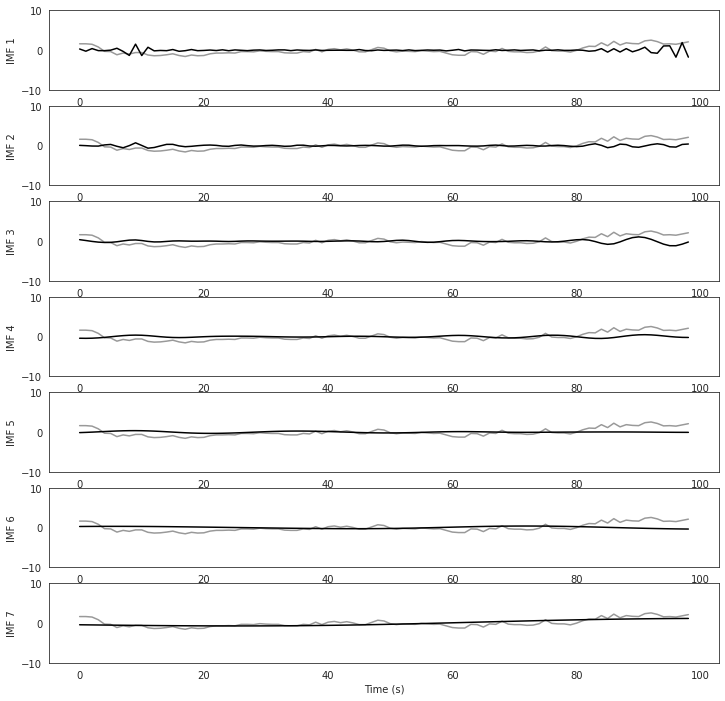

In [ ]:
plot_IMFS(imf_direction)